In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, concatenate
from keras.layers import GaussianDropout, GaussianNoise
from keras.layers import GRU, Bidirectional, TimeDistributed
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import os
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
# DATASET
DATASET_COLUMNS = ["target", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 6
W2V_SIZE = 200

SEQUENCE_LENGTH = 200

MAXLEN = 100
MAX_SENTENCES = 15
MAX_WORDS = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

# class defining the custom attention layer
class HierarchicalAttentionNetwork(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [4]:
df_train = pd.read_csv("yelp2015/train.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df_test = pd.read_csv("yelp2015/test.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
def preprocess(text):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
      tokens.append(token)
    return " ".join(tokens)

In [6]:
%%time
df_train.text = df_train.text.apply(lambda x: preprocess(x))
df_test.text = df_test.text.apply(lambda x: preprocess(x))

Wall time: 1min 1s


In [7]:
decode_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df_train.target = df_train.target.apply(lambda x: decode_sentiment(x))
df_test.target = df_test.target.apply(lambda x: decode_sentiment(x))

Wall time: 406 ms


In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\covin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
%%time
documents = [_text.split() for _text in df_train.text]

Wall time: 11.4 s


In [11]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [12]:
w2v_model.build_vocab(documents)

2020-04-08 20:20:03,070 : INFO : collecting all words and their counts
2020-04-08 20:20:03,073 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-08 20:20:03,346 : INFO : PROGRESS: at sentence #10000, processed 1360163 words, keeping 28152 word types
2020-04-08 20:20:03,599 : INFO : PROGRESS: at sentence #20000, processed 2699906 words, keeping 40261 word types
2020-04-08 20:20:03,858 : INFO : PROGRESS: at sentence #30000, processed 4043188 words, keeping 48931 word types
2020-04-08 20:20:04,115 : INFO : PROGRESS: at sentence #40000, processed 5357017 words, keeping 55168 word types
2020-04-08 20:20:04,370 : INFO : PROGRESS: at sentence #50000, processed 6668799 words, keeping 60350 word types
2020-04-08 20:20:04,626 : INFO : PROGRESS: at sentence #60000, processed 7961262 words, keeping 64954 word types
2020-04-08 20:20:04,893 : INFO : PROGRESS: at sentence #70000, processed 9318978 words, keeping 70296 word types
2020-04-08 20:20:05,163 : INFO : PROGRE

In [13]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 65236


In [14]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-04-08 20:20:36,651 : INFO : training model with 8 workers on 65236 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-04-08 20:20:37,665 : INFO : EPOCH 1 - PROGRESS: at 1.62% examples, 1057111 words/s, in_qsize 13, out_qsize 2
2020-04-08 20:20:38,668 : INFO : EPOCH 1 - PROGRESS: at 3.46% examples, 1133015 words/s, in_qsize 15, out_qsize 0
2020-04-08 20:20:39,681 : INFO : EPOCH 1 - PROGRESS: at 5.36% examples, 1154831 words/s, in_qsize 13, out_qsize 2
2020-04-08 20:20:40,697 : INFO : EPOCH 1 - PROGRESS: at 7.30% examples, 1169103 words/s, in_qsize 15, out_qsize 0
2020-04-08 20:20:41,713 : INFO : EPOCH 1 - PROGRESS: at 9.27% examples, 1177323 words/s, in_qsize 14, out_qsize 1
2020-04-08 20:20:42,713 : INFO : EPOCH 1 - PROGRESS: at 11.11% examples, 1186485 words/s, in_qsize 15, out_qsize 0
2020-04-08 20:20:43,725 : INFO : EPOCH 1 - PROGRESS: at 13.00% examples, 1188448 words/s, in_qsize 13, out_qsize 2
2020-04-08 20:20:44,725 : INFO : EPOCH 1 - PROGRES

Wall time: 28min 46s


(2169056292, 2910826400)

In [15]:
from nltk import tokenize

reviews = []
labels = []
texts = []

for idx, _ in df_train.iterrows():
    text = df_train.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_train.target[idx])

TRAIN_SIZE = len(texts)

for idx, _ in df_test.iterrows():
    text = df_test.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_test.target[idx])

In [16]:
from keras.preprocessing.text import text_to_word_sequence

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTENCES:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 245214 unique tokens.


In [17]:
from keras.utils.np_utils import to_categorical

labels = to_categorical(np.asarray(labels))
print('Shape of reviews (data) tensor:', data.shape)
print('Shape of sentiment (label) tensor:', labels.shape)

Shape of reviews (data) tensor: (700000, 15, 100)
Shape of sentiment (label) tensor: (700000, 5)


In [18]:
x_train = data[:TRAIN_SIZE]
y_train = labels[:TRAIN_SIZE]
x_test = data[TRAIN_SIZE:]
y_test = labels[TRAIN_SIZE:]

In [19]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAXLEN, trainable=False)

In [20]:
sentence_input = Input(shape=(MAXLEN,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
attn_word = HierarchicalAttentionNetwork(100)(lstm_word)
sentenceEncoder = Model(sentence_input, attn_word)

review_input = Input(shape=(MAX_SENTENCES, MAXLEN), dtype='int32')
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(50, return_sequences=True))(review_encoder)
attn_sentence = HierarchicalAttentionNetwork(100)(lstm_sentence)
preds = Dense(5, activation='softmax')(attn_sentence)
model = Model(review_input, preds)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-04-08 20:54:19,402 : WARNING : From C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


tracking <tf.Variable 'hierarchical_attention_network_1/Variable:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_1/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_1/Variable_2:0' shape=(100, 1) dtype=float32> u
tracking <tf.Variable 'hierarchical_attention_network_2/Variable:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_2/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_2/Variable_2:0' shape=(100, 1) dtype=float32> u


In [21]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100)           49128500  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 100)           45300     
_________________________________________________________________
hierarchical_attention_netwo (None, 100)               10200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 49,184,505
Trainable params: 141,505
Non-trainable params: 49,043,000
_________________________________________________________________


In [22]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, mode='max')]

In [23]:
print("model fitting - Hierachical attention network")
history = model.fit(x_train, y_train, validation_split=0.2, nb_epoch=10, batch_size=64, callbacks=callbacks)

model fitting - Hierachical attention network


C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


2020-04-08 20:54:27,807 : WARNING : From C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 520000 samples, validate on 130000 samples
Epoch 1/10
520000/520000 [==============================] - 3008s 6ms/step - loss: 1.0517 - acc: 0.5366 - val_loss: 0.8981 - val_acc: 0.6153
Epoch 2/10
520000/520000 [==============================] - 3020s 6ms/step - loss: 0.9445 - acc: 0.5881 - val_loss: 0.8831 - val_acc: 0.6196
Epoch 3/10
520000/520000 [==============================] - 3096s 6ms/step - loss: 0.9221 - acc: 0.5982 - val_loss: 0.8795 - val_acc: 0.6191
Epoch 4/10
520000/520000 [==============================] - 3075s 6ms/step - loss: 0.9077 - acc: 0.6044 - val_loss: 0.8579 - val_acc: 0.6297
Epoch 5/10
520000/520000 [==============================] - 3077s 6ms/step - loss: 0.8966 - acc: 0.6094 - val_loss: 0.8605 - val_acc: 0.6293
Epoch 6/10
520000/520000 [==============================] - 3076s 6ms/step - loss: 0.8878 - acc: 0.6130 - val_loss: 0.8518 - val_acc: 0.6316
Epoch 7/10
520000/520000 [==============================] - 3077s 6ms/step - loss: 0.8807 - acc: 0.616

In [24]:
%%time
score = model.evaluate(x_test, y_test, batch_size=100)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

50000/50000 [==============================] - 103s 2ms/step

ACCURACY: 0.607479989528656
LOSS: 0.8974802836179733
Wall time: 1min 43s


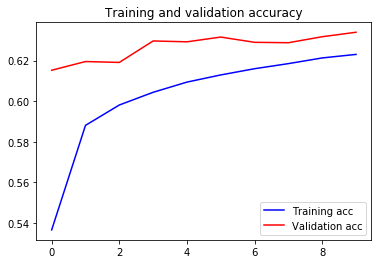

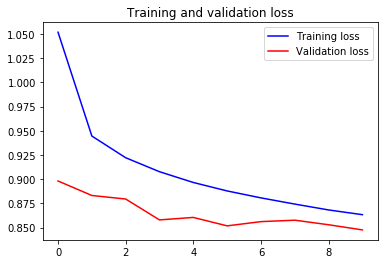

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()